# GEM ML Framework Demonstrator - Deforestation Detection
In these notebooks, we provide an in-depth example of how the GEM ML framework can be used for segmenting deforested areas using Sentinel-2 imagery as input and the [TMF dataset](https://forobs.jrc.ec.europa.eu/TMF/) as a reference.
The idea is to use a neural network (NN) model for the analysis.
Thanks to the flexibility of the GEM ML framework, we can easily substitute the model in the future by adjusting only the configuration file.
We will have a look at the following notebooks separately:
- 00_Configuration
- 01_DataAcquisition
- 02_DataNormalization
- 03_TrainingValidationTesting
- 04_Inference_Clouds

Authors: Michael Engel (m.engel@tum.de) and Joana Reuss (joana.reuss@tum.de)

-----------------------------------------------------------------------------------

# Data Acquisition
Here, we define our `EOWorkflow` for downloading the desired data.

In [1]:
import datetime as dt
import os

import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

from folium import plugins as foliumplugins
from sentinelhub import DataCollection, UtmZoneSplitter
from shapely.geometry import Polygon

from libs.ConfigME import Config
from tasks.PickIdxTask import PickIdxTask
from tasks.SaveValidTask import SaveValidTask
from tasks.TDigestTask import TDigestTask
from utils.parse_time_interval_observations import parse_time_interval_observations

from eolearn.core import EOExecutor, EONode, EOPatch, EOWorkflow, FeatureType, MapFeatureTask, OverwritePermission, \
    ZipFeatureTask
from eolearn.features.feature_manipulation import SpatialResizeTask
from eolearn.features.utils import ResizeLib, ResizeMethod
from eolearn.io import ImportFromTiffTask, SentinelHubInputTask

print("Working Directory:", os.getcwd())

/home/michael/anaconda3/envs/eolearn_water/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Incorporating libs!
Incorporating tasks!
Incorporating utils!
Working Directory: /home/michael/Documents/GEM/TUM-Git/eo-learn-examples/GEM-ML/Example_DeforestationDetection


## Config
First, we load our configuration file which provides all information we need throughout the script and linuxify our paths (if you are working on a Windows machine) as the eo-learn filesystem manager does not support backslashes for now.

In [2]:
#%% load configuration file
config = Config.LOAD("config.dill")

#%% linuxify
config.linuxify()

## Area of Interest
Let's load the geojson of our AOIs for training, validation and testing, respectively.

In [3]:
#%% load geojson files
aoi_train = gpd.read_file(config['AOI_train'])
aoi_validation = gpd.read_file(config['AOI_validation'])
aoi_test = gpd.read_file(config['AOI_test'])

#%% find best suitable crs and transform to it
crs_train = aoi_train.estimate_utm_crs()
aoi_train = aoi_train.to_crs(crs_train)
aoi_train = aoi_train.buffer(config['AOIbuffer'])

crs_validation = aoi_validation.estimate_utm_crs()
aoi_validation = aoi_validation.to_crs(crs_validation)
aoi_validation = aoi_validation.buffer(config['AOIbuffer'])

crs_test = aoi_test.estimate_utm_crs()
aoi_test = aoi_test.to_crs(crs_test)
aoi_test = aoi_test.buffer(config['AOIbuffer'])

#%% dict for query
aois = {"train":aoi_train,
        "validation":aoi_validation,
        "test":aoi_test}

In [4]:
#%% calculate and print size
aoi_train_shape = aoi_train.geometry
aoi_train_width = [geom.bounds[2]-geom.bounds[0] for geom in aoi_train_shape]
aoi_train_height = [geom.bounds[3]-geom.bounds[1] for geom in aoi_train_shape]
print(f"Dimension of the training area is {np.sum(np.array(aoi_train_width)*np.array(aoi_train_height)):.2e} m2")
aoi_validation_shape = aoi_validation.geometry
aoi_validation_width = [geom.bounds[2]-geom.bounds[0] for geom in aoi_validation_shape]
aoi_validation_height = [geom.bounds[3]-geom.bounds[1] for geom in aoi_validation_shape]
print(f"Dimension of the validation area is {np.sum(np.array(aoi_validation_width)*np.array(aoi_validation_height)):.2e} m2")
aoi_test_shape = aoi_test.geometry
aoi_test_width = [geom.bounds[2]-geom.bounds[0] for geom in aoi_test_shape]
aoi_test_height = [geom.bounds[3]-geom.bounds[1] for geom in aoi_test_shape]
print(f"Dimension of the test area is {np.sum(np.array(aoi_test_width)*np.array(aoi_test_height)):.2e} m2")

Dimension of the training area is 4.72e+10 m2
Dimension of the validation area is 1.18e+10 m2
Dimension of the test area is 9.90e+09 m2


### Split into smaller tiles

Since our AOIs **are too large**, we split them into a set of smaller bboxes using the `UtmZoneSplitter`.

In [5]:
#%% create a splitter to obtain a list of bboxes
bbox_splitter_train = UtmZoneSplitter(aoi_train_shape, aoi_train.crs, config["patchpixelwidth"]*config["resolution"])
bbox_splitter_validation = UtmZoneSplitter(aoi_validation_shape, aoi_validation.crs, config["patchpixelwidth"]*config["resolution"])
bbox_splitter_test = UtmZoneSplitter(aoi_test_shape, aoi_test.crs, config["patchpixelwidth"]*config["resolution"])

bbox_list_train = np.array(bbox_splitter_train.get_bbox_list())
info_list_train = np.array(bbox_splitter_train.get_info_list())
bbox_list_validation = np.array(bbox_splitter_validation.get_bbox_list())
info_list_validation = np.array(bbox_splitter_validation.get_info_list())
bbox_list_test = np.array(bbox_splitter_test.get_bbox_list())
info_list_test = np.array(bbox_splitter_test.get_info_list())

#%% dict for query
bbox_lists = {"train":bbox_list_train,
              "validation":bbox_list_validation,
              "test":bbox_list_test}
info_lists = {"train":info_list_train,
              "validation":info_list_validation,
              "test":info_list_test}

### Visualization (not necessary)

The **bbox list would be sufficient** for starting the training procedure using eo-learn.
To check if we muddled up something, however, we want to visualize it!
Since our area of interest is rather large, we face the problem of multiple coordinate reference systems.
Unfortunately, **geopandas does not support multiple crs in one dataframe**, as described [here](https://github.com/sentinel-hub/sentinelhub-py/issues/123).
Hence, we have to define a set of tiles for each crs separately.

For later parallelization, we have to set an entry point here and the [folium](https://python-visualization.github.io/folium/) based visualization as we do want our notebooks to work on both Linux and Windows platforms.
Because of that procedure, you can simply export the notebook as a python-script for parallel execution on Windows machines.

In [6]:
if __name__=='__main__':
    tiles = []
    crss_uniques = []
    for set_ in ["train","validation","test"]:
        tiles.append([])
        #%% determine number of coordinate reference systems
        crss = [bbox_._crs for bbox_ in bbox_lists[set_]]
        crss_unique = np.array(list(dict.fromkeys(crss)))
        crss_uniques.append(crss_unique)
        n_crss = len(crss_unique)

        #%% sort geometries and indices by crs and store to disk
        geometries = [[] for i in range(n_crss)]
        idxs = [[] for i in range(n_crss)]
        idxs_x = [[] for i in range(n_crss)]
        idxs_y = [[] for i in range(n_crss)]
        for i,info in enumerate(info_lists[set_]):
            idx_ = np.argmax(crss_unique==bbox_lists[set_][i]._crs)

            geometries[idx_].append(Polygon(bbox_lists[set_][i].get_polygon())) # geometries sorted by crs
            idxs[idx_].append(info["index"]) # idxs sorted by crs
            idxs_x[idx_].append(info["index_x"]) # idxs_x sorted by crs
            idxs_y[idx_].append(info["index_y"]) # idxs_y sorted by crs

        for i in range(n_crss):
            #%% build dataframe of our areas of interest (and each crs)
            tiles[-1].append(
                gpd.GeoDataFrame(
                    {"index": idxs[i], "index_x": idxs_x[i], "index_y": idxs_y[i]},
                    crs="EPSG:"+crss_unique[i]._value_,
                    geometry=geometries[i]
                )
            )
            #%%% save dataframes to shapefiles
            tiles[-1][-1].to_file(os.path.join(config["dir_results"],f"grid_aoi_{_}_{i}_EPSG{str(crss_unique[i]._value_)}.gpkg"), driver="GPKG")

        #%% print amount of patches
        print("Total number of tiles in " + set_ + ":",len(bbox_lists[set_]))

Total number of tiles in train: 1981
Total number of tiles in validation: 541
Total number of tiles in test: 425


We have sorted the tiles accordingly to their corresponding crs and would now like to visualize them in a nice map.

Here, it is important to **reproject the tiles** to the crs of our **mapping application** (EPSG:4326). We do that only for purpose of mapping them, the `bbox_lists` **is not affected** by this.

In [7]:
if __name__=='__main__':
    #%% visualize using folium
    aoi_folium = aoi_validation.to_crs("EPSG:4326") # use validation for visualisation
    location = [np.mean(aoi_folium.centroid.y),np.mean(aoi_folium.centroid.x)]

    mapwindow = folium.Map(location=location, tiles='Stamen Terrain', zoom_start=6)

    colors = ["blue","green","red"]
    for i,_ in enumerate(["train","validation","test"]):
        #%%% add aois
        #%%%% train
        mapwindow.add_child(
            folium.features.Choropleth(
                aois[_].to_crs("EPSG:4326").to_json(),
                fill_color=colors[i],
                nan_fill_color=colors[i],
                fill_opacity=0,
                nan_fill_opacity=0.5,
                line_color=colors[i],
                line_weight=1,
                line_opacity=0.6,
                smooth_factor=5,
                name=f"{_} area"
            )
        )

        #%%% add grids in blue color
        for t_,tiles_ in enumerate(tiles[i]):
            cp = folium.features.Choropleth(
                    tiles_.to_crs("EPSG:4326").to_json(),
                    fill_color=colors[i],
                    nan_fill_color="black",
                    fill_opacity=0,
                    nan_fill_opacity=0.5,
                    line_color=colors[i],
                    line_weight=0.5,
                    line_opacity=0.6,
                    smooth_factor=5,
                    name=f"{_} grid EPSG:{crss_uniques[i][t_]._value_}"
                ).add_to(mapwindow)

            # display index next to cursor
            folium.GeoJsonTooltip(
                ['index'],
                aliases=['Index:'],
                labels=False,
                style="background-color:rgba(0,101,189,0.4); border:2px solid white; color:white;",
                ).add_to(cp.geojson)

    #%%% add some controls
    folium.LayerControl().add_to(mapwindow)
    foliumplugins.Fullscreen(force_separate_button=True).add_to(mapwindow)

    #%%% save, render and display
    mapwindow.save(os.path.join(config["dir_results"],'gridmap.html'))
    mapwindow.render()
    mapwindow

/tmp/ipykernel_265811/3937325905.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location = [np.mean(aoi_folium.centroid.y),np.mean(aoi_folium.centroid.x)]
/tmp/ipykernel_265811/3937325905.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location = [np.mean(aoi_folium.centroid.y),np.mean(aoi_folium.centroid.x)]


# eo-learn workflow
Now it is time to define our `eo-learn` workflow. It consists of the following elements

- __EOTask__
- __EONode__
- __EOWorkflow__

## EOTasks

We define and create the follwing [EOTasks](https://eo-learn.readthedocs.io/en/latest/eotasks.html)

###  1. Input data
#### 1.1 Querying Sentinel data
>- __*task_data*__: We take a [Sentinel-Hub-Input-Task](https://eo-learn.readthedocs.io/en/latest/eolearn.io.sentinelhub_process.html#eolearn.io.sentinelhub_process.SentinelHubInputTask) for querying **Sentinel-2 data**. 
>- __*task_data_pick*__: We use a __`PickIdxTask`__ in order to pick the correct date of the queried data.
>- __*task_data_pick_dmask*__ and __*task_data_pick_cmask*__: The __`PickIdxTask`__ will also be applied to the dataMask as well as the cloudMask.

#### 1.2 Normalization
>- __*task_data_tdigest*__: The T-Digest representation of our data will be computed by using a __`TDigestTask`__ for later normalization.

#### 1.3 Area filtering:
>- __*task_data_check*__: We filter or mask out non-valid data using a [MapFeatureTask](https://eo-learn.readthedocs.io/en/latest/_modules/eolearn/core/core_tasks.html#MapFeatureTask).


###  2. Reference data
#### 2.1 Importing reference maps
>- __*task_reference*__: We use an [Import-From-Tiff-Task](https://eo-learn.readthedocs.io/en/latest/reference/eolearn.io.raster_io.html#eolearn.io.raster_io.ImportFromTiffTask) to load the [TMF dataset].

#### 2.2 Label mapping
>- __*task_reference_labelmapping*__: We use a [MapFeatureTask](https://eo-learn.readthedocs.io/en/latest/_modules/eolearn/core/core_tasks.html#MapFeatureTask) for mapping the corresponding labels.

#### 2.3 Resizing:
>- __*task_reference_resize*__: Furthermore, we adjust the spatial resolution of the provided reference maps through a [SpatialResizeTask](https://eo-learn.readthedocs.io/en/latest/reference)

#### 2.4 Cloud masking and mapping:
>- __*task_reference_cloudmapping*__: We use the mask calculated by __*S2Cloudless*__ and a [ZipFeatureTask](https://eo-learn.readthedocs.io/en/latest/_modules/eolearn/core/core_tasks.html#ZipFeatureTask) in order to map the new class `clouds` to the reference data.

#### 2.5 Area masking:
>- __*task_reference_mask*__: We mask out non-valid areas using a [MapFeatureTask](https://eo-learn.readthedocs.io/en/latest/_modules/eolearn/core/core_tasks.html#MapFeatureTask).


###  3. Merging and Saving
>- __*task_save*__: We save the created EOPatches using a __`SaveValidTask`__.

### 1. Input data:

#### 1.1 Querying Sentinel data

The date of our reference is considered to be the 2021-12-31.
That is, we choose the observation with max `config["maxcc"]` cloud coverage closest ahead of that date.

Furthermore, we select the following Sentinel-2 bands: B02, B02, B04, B08, B11, B12

In [8]:
#%% Sentinel-Hub-Input-Task
task_data = SentinelHubInputTask(
    data_collection = DataCollection.SENTINEL2_L1C,
    size = None,
    resolution = config["resolution"],
    bands_feature = (FeatureType.DATA, "data"),
    bands = ["B02","B03","B04","B08","B11","B12"],
    additional_data = [(FeatureType.MASK, "dataMask", "dmask_data"),(FeatureType.MASK, "CLM", "cmask_data")],
    evalscript = None,
    maxcc = config["maxcc"],
    time_difference = dt.timedelta(hours=1),
    cache_folder = config["dir_cache"],
    max_threads = config["threads"],
    config = config["SHconfig"],
    bands_dtype = np.float32,
    single_scene = False,
    mosaicking_order = "mostRecent",
    aux_request_args = None
)

We are querying the date closest to the cutoff date with a maximum of `config["maxcc"]` cloud coverage before we download the data. This ensures that we in fact pick the correct date.

However, for the sake of safety, we still use the __`PickIdxTask`__ here.

In [9]:
#%% Pick-Idx-Task
task_data_pick = PickIdxTask(
    in_feature = (FeatureType.DATA, "data"),
    out_feature = None, # None for replacing in_feature
    idx = [[-1],...] # -1 in brackets for keeping dimensions of numpy array
)

The same holds true for both our data- and the cloud-mask.

In [10]:
#%% Pick-Idx-Task data mask
task_data_pick_dmask = PickIdxTask(
    in_feature = (FeatureType.MASK, "dmask_data"),
    out_feature = None, # None for replacing in_feature
    idx = [[-1],...] # -1 in brackets for keeping dimensions of numpy array
)

#%% Pick-Idx-Task cloud mask
task_data_pick_cmask = PickIdxTask(
    in_feature = (FeatureType.MASK, "cmask_data"),
    out_feature = None, # None for replacing in_feature
    idx = [[-1],...] # -1 in brackets for keeping dimensions of numpy array
)

#### 1.2 Normalization

For later normalization of our dataset, we will use the __*T-Digest algorithm*__.
It is designed for quantile approximation close to the tails which we need for the common linear quantile scaler in the realm of ML.

In [11]:
#%% T-Digest-Task
task_data_tdigest = TDigestTask(
    in_feature = (FeatureType.DATA, 'data'),
    out_feature = (FeatureType.SCALAR_TIMELESS, 'tdigest_data'),
    mode = None,
    pixelwise = False
)

#### 1.3 Area filtering

So far, we have defined the necessary EOTasks for our input and reference data. However, both tasks still contain areas which don't **provide any reasonable data** at all or not in a meaningful way, as __*indefinite land cover*__, for example. Therefore, we still have to add the corresponding areas to the dataMask in order to later filter the respective (non-valid) EOPatches from the input. This will be done based on the analysis of the [MapFeatureTask](https://eo-learn.readthedocs.io/en/latest/_modules/eolearn/core/core_tasks.html#MapFeatureTask) which will then be applied to the dataMask.
Furthermore, we will apply a similar procedure to the reference map in step __2.5 Area masking__.

In [12]:
#%% Filter out incomplete input data patches
def checker_nodata(array):
    return bool(np.all(array))

task_data_check = MapFeatureTask(
    input_features = (FeatureType.MASK, "dmask_data"),
    output_features = (FeatureType.META_INFO, "valid"),
    map_function = checker_nodata
)

### 2. Reference data

#### 2.1 Importing reference maps
We use an [ImportFromTiffTask](https://eo-learn.readthedocs.io/en/latest/_modules/eolearn/io/raster_io.html#ImportFromTiffTask) for converting our reference data from a GeoTIFF file into an EOPatch.

In [13]:
#%% Import-From-Tiff-Task
task_reference = ImportFromTiffTask(
    feature = (FeatureType.MASK_TIMELESS, "reference"),
    folder = config["path_reference"],
    use_vsi = False,
    timestamp_size = None
)

#### 2.2 Label mapping

We apply our labelmapping using a [MapFeatureTask](https://eo-learn.readthedocs.io/en/latest/_modules/eolearn/core/core_tasks.html#MapFeatureTask).

In [14]:
#%% apply labelmapping
def labelmapper(reference,mapping):
    refcopy = reference.copy()
    for key,value in mapping.items():
        refcopy[reference==key] = value
    return refcopy

task_reference_labelmapping = MapFeatureTask(
    input_features = (FeatureType.MASK_TIMELESS, "reference"),
    output_features = (FeatureType.MASK_TIMELESS, "reference"),
    map_function = labelmapper,
    mapping = config["labelmapping"]
)

#### 2.3 Resizing
Since the reference data has been acquired using the Landsat missions with 30m resolution, we have to resize our reference to our chosen resolution first.

In [15]:
task_reference_resize = SpatialResizeTask(
    features = (FeatureType.MASK_TIMELESS, "reference"),
    resize_type = "new_size",
    height_param = config["patchpixelwidth"],
    width_param = config["patchpixelwidth"],
    resize_method = ResizeMethod.NEAREST,
    resize_library = ResizeLib.PIL
)

#### 2.4. Cloud masking and mapping:

Further, we want our model to segment clouds as well.
Hence, we use the __*S2Cloudless*__ (cf. *cmask_data*) and apply some mapping to the reference data using the [ZipFeatureTask](https://eo-learn.readthedocs.io/en/latest/_modules/eolearn/core/core_tasks.html#ZipFeatureTask) in order to combine two features: the reference map and the created cloud mask.

In [16]:
def mask_key_value_zipper(*arrays,key=0,value=0):
    reference = arrays[0]
    mask = arrays[1].squeeze(0) # squeeze as originally temporal feature type
    reference[mask==key] = value
    return reference

task_reference_cloudmapping = ZipFeatureTask(
    input_features = [
        (FeatureType.MASK_TIMELESS, "reference"),
        (FeatureType.MASK, "cmask_data")
    ],
    output_feature = (FeatureType.MASK_TIMELESS, "reference"),
    zip_function = mask_key_value_zipper,
    key = 1,
    value = config["class_clouds"]
)

#### 2.5. Area masking
As described in __1.3 Area filtering__, we have to filter out non-valid areas from both the input (satellite) data, as well as the reference map.
Therefore, we again apply a [MapFeatureTask](https://eo-learn.readthedocs.io/en/latest/_modules/eolearn/core/core_tasks.html#MapFeatureTask), this time to our reference map in order to mask out the corresponding areas which are labeled with the __*indefinitie land cover*__ class.

For the indefinite land cover in our reference data, we calculate a mask using the [MapFeatureTask](https://eo-learn.readthedocs.io/en/latest/_modules/eolearn/core/core_tasks.html#MapFeatureTask).

In [17]:
#%% calculate mask
def calculatemask(reference,key):
    mask = np.ones(reference.shape, dtype=np.uint8)
    mask[reference==key] = 0
    return mask

task_reference_mask = MapFeatureTask(
    input_features = (FeatureType.MASK_TIMELESS, "reference"),
    output_features = (FeatureType.MASK_TIMELESS, "mask_reference"),
    map_function = calculatemask,
    key = config["class_indefinite"]
)

### 3. Merging and Saving
We save the create `EOPatches` using a __`SaveValidTask`__. 
Only **valid EOPatches** are saved based on the previously filtered input data in __1.3__.

Note the __*compression*__ keyword - if not set, the memory consumption may get really large!

In [18]:
#%% save EOPatches
task_save = SaveValidTask(
    feature_to_check = (FeatureType.META_INFO, "valid"),
    path = config["dir_data"],
    filesystem = None,
    config = config["SHconfig"],
    overwrite_permission = OverwritePermission.OVERWRITE_PATCH,
    compress_level = 2
)

## EONodes
After we have defined all necessary __`EOTasks`__, we initialize the __`EONodes`__ which will be used in order to run through the workflow afterwards.

In [19]:
#%% input nodes
node_data = EONode(
    task = task_data,
    inputs = [],
    name = "load Sentinel-2 data"
)
node_data_pick = EONode(
    task = task_data_pick,
    inputs = [node_data],
    name = "pick closest observation to reference for data"
)
node_data_pick_dmask = EONode(
    task = task_data_pick_dmask,
    inputs = [node_data_pick],
    name = "pick closest observation to reference for data mask"
)
node_data_pick_cmask = EONode(
    task = task_data_pick_cmask,
    inputs = [node_data_pick_dmask],
    name = "pick closest observation to reference for cloud mask"
)
node_data_tdigest = EONode(
    task = task_data_tdigest,
    inputs = [node_data_pick_cmask],
    name = "compute T-Digest of data"
)
node_data_check = EONode(
    task = task_data_check,
    inputs = [node_data_tdigest],
    name = "check data for completeness"
)

#%% reference nodes
node_reference = EONode(
    task = task_reference,
    inputs = [node_data_check],
    name = "load reference from disk"
)
node_reference_labelmapping = EONode(
    task = task_reference_labelmapping,
    inputs = [node_reference],
    name = "apply labelmapping"
)
node_reference_resize = EONode(
    task = task_reference_resize,
    inputs = [node_reference_labelmapping],
    name = "apply labelmapping"
)
node_reference_cloudmapping = EONode(
    task = task_reference_cloudmapping,
    inputs = [node_reference_resize],
    name = "map clouds into reference"
)
node_reference_mask = EONode(
    task = task_reference_mask,
    inputs = [node_reference_cloudmapping],
    name = "mask indefinite reference data"
)

We could either put every single one of the above nodes in the constructor using a list or define our whole workflow by just using a single node `node_save` created through our `task_save`.

In [20]:
#%% merging and saving nodes
node_save = EONode(
    task = task_save,
    inputs = [node_reference_mask],
    name = "save valid EOPatch"
)

## Final EOWorkflow
We define the final workflow using the single node `node_save`.

In [21]:
workflow = EOWorkflow.from_endnodes(node_save)
#workflow.dependency_graph()

### Test Workflow
Now, we want to test our workflow with some arbitrary patch (from our training set) at some arbitrary date (not included into study).

In [22]:
workflow.execute({
    node_data: {"bbox":bbox_list_train[596],"time_interval":("2022-10-01","2022-10-01")},
    node_save: {"eopatch_folder":"testpatch"}
})
eopatch = EOPatch.load(os.path.join(config["dir_data"],"testpatch"))
eopatch

EOPatch(
  data={
    data: numpy.ndarray(shape=(1, 256, 256, 6), dtype=float32)
  }
  mask={
    cmask_data: numpy.ndarray(shape=(1, 256, 256, 1), dtype=uint8)
    dmask_data: numpy.ndarray(shape=(1, 256, 256, 1), dtype=bool)
  }
  mask_timeless={
    mask_reference: numpy.ndarray(shape=(256, 256, 1), dtype=uint8)
    reference: numpy.ndarray(shape=(256, 256, 1), dtype=uint8)
  }
  scalar_timeless={
    tdigest_data: numpy.ndarray(shape=(6,), dtype=object)
  }
  meta_info={
    maxcc: 0.3
    size_x: 256
    size_y: 256
    time_difference: 3600.0
    time_interval: ['2022-10-01T00:00:00', '2022-10-01T23:59:59']
    valid: True
  }
  bbox=BBox(((558080.0, 9809920.0), (563200.0, 9815040.0)), crs=CRS('32721'))
  timestamp=[datetime.datetime(2022, 10, 1, 14, 13, 7)]
)

Let's have a look at our eopatch.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


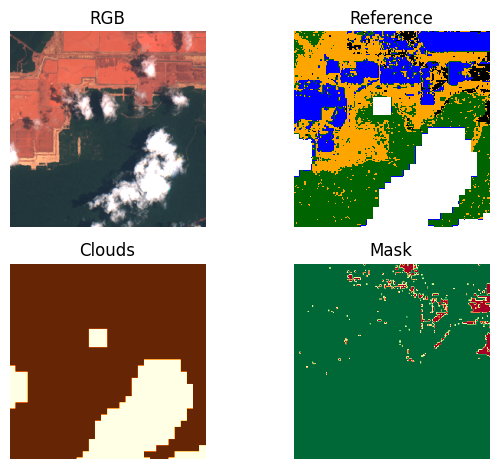

In [23]:
RGB = eopatch["data"]["data"][0,...,np.array([2,1,0])].transpose(1,2,0)

#%% plot testpatch
plt.figure()
plt.subplot(221)
plt.imshow(RGB*2.5)
plt.title("RGB")
plt.axis("off")
plt.subplot(222)
plt.imshow(eopatch["mask_timeless"]["reference"],vmin=0,vmax=config["num_classes"],cmap=config["cmap_reference"])
plt.title("Reference")
plt.axis("off")
plt.subplot(223)
plt.imshow(eopatch["mask"]["cmask_data"][0,...],vmin=0,vmax=1,cmap="YlOrBr_r")
plt.title("Clouds")
plt.axis("off")
plt.subplot(224)
plt.imshow(eopatch["mask_timeless"]["mask_reference"],vmin=0,vmax=1,cmap="RdYlGn")
plt.title("Mask")
plt.axis("off")

plt.tight_layout()
plt.savefig(os.path.join(config["dir_imgs"],"testpatch.png"),dpi=300)

## Downloading Data
Now it's time to download the data.
Therefore, we have to define __workflow arguments__, both temporal and spatial.
Note that we only want to download the data that is not yet present on our device.
Hence, we check for existence first and assign arguments afterwards.

In [24]:
workflow_args = []
for _ in ["train","validation","test"]:
    print(_)
    bbox_list_ = bbox_lists[_]
    for i in range(len(bbox_list_)):
        print(f"\r{i+1}/{len(bbox_list_)}",end="\r")
        try:
            timestamps = parse_time_interval_observations( ### Will be replaced by new time-filter
                time_interval = (config[f"start_{_}"],config[f"end_{_}"]),
                bbox = bbox_list_[i], 
                data_collection = DataCollection.SENTINEL2_L1C, 
                check_timedelta = config["checktimedelta"],
                include_borders = True,
                time_difference = dt.timedelta(hours=1,seconds=0), 
                maxcc = config["maxcc"], 
                config = config["SHconfig"]
            )

            dir_ = f"{_}/eopatch_{i}_{timestamps[0].strftime(r'%Y-%m-%dT%H-%M-%S_%Z')}_{timestamps[1].strftime(r'%Y-%m-%dT%H-%M-%S_%Z')}"
            if not os.path.exists(os.path.join(config["dir_data"],dir_)):### and False: ### 
                workflow_args.append(
                    {
                        node_data: {"bbox":bbox_list_[i],"time_interval":timestamps},
                        node_save: {"eopatch_folder":dir_}
                    }
                )
        except Exception as e:
            print(e)
    print()

print(f"Number of downloads: {len(workflow_args)}")

train
1981/1981
validation
541/541
test
425/425
Number of downloads: 161


In [25]:
workflow_args[-1]

{EONode(task=<eolearn.io.sentinelhub_process.SentinelHubInputTask object at 0x7f8772447c40>, inputs=(), name='load Sentinel-2 data'): {'bbox': BBox(((435200.0, 9589760.0), (440320.0, 9594880.0)), crs=CRS('32722')),
  'time_interval': (datetime.datetime(2021, 9, 30, 13, 53, 25, tzinfo=tzutc()),
   datetime.datetime(2021, 12, 31, 23, 59, 59, tzinfo=<UTC>))},
 EONode(task=<tasks.SaveValidTask.SaveValidTask object at 0x7f87721923d0>, inputs=(EONode(task=<eolearn.core.core_tasks.MapFeatureTask object at 0x7f87721cbb80>, inputs=(EONode(task=<eolearn.core.core_tasks.ZipFeatureTask object at 0x7f87722d8370>, inputs=(EONode(task=<eolearn.features.feature_manipulation.SpatialResizeTask object at 0x7f8772192700>, inputs=(EONode(task=<eolearn.core.core_tasks.MapFeatureTask object at 0x7f87721cbbb0>, inputs=(EONode(task=<eolearn.io.raster_io.ImportFromTiffTask object at 0x7f87722d8e50>, inputs=(EONode(task=<eolearn.core.core_tasks.MapFeatureTask object at 0x7f87723fee20>, inputs=(EONode(task=<tasks

## Executor
So far, we have defined our
- Area of Interest
- Input and reference data
- EOWorkflow
- Execution (or workflow) arguments

What is left, is the definition of our __EOExecutor__. This still has to be done!

In [26]:
#%% define executor
executor = EOExecutor(workflow, workflow_args, save_logs=True)

Let it run!
That may take a while...

In [27]:
#%% run
print(f"Will start data acquisition using {config['threads']} threads!")
executor.run(workers=config["threads"])
executor.make_report()

Will start data acquisition using 5 threads!


100%|█████████████████████████████████████████| 161/161 [08:58<00:00,  3.35s/it]
/home/michael/anaconda3/envs/eolearn_water/lib/python3.8/site-packages/eolearn/visualization/eoexecutor.py:57: EOUserWarning: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH.
Please install the system package 'graphviz' (in addition to the python package) to have the dependency graph in the final report!
  warnings.warn(


### Downloaded Data
After a long time, our executor has finally finished its work.
Let's **check** if anything unexpected happened.

In [28]:
failed_ids = executor.get_failed_executions()
if failed_ids:
    print(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_path()}"
    )

Let's have a look at how many `EOPatches` got stored to disk.

In [29]:
print(f"Number of stored train EOPatches: {len(os.listdir(config['dir_train']))}")
print(f"Number of stored validation EOPatches: {len(os.listdir(config['dir_validation']))}")
print(f"Number of stored test EOPatches: {len(os.listdir(config['dir_test']))}")
print()
print(f"Number of downloads: {len(workflow_args)}")
print(f"Total number of EOPatches: {len(os.listdir(config['dir_train']))+len(os.listdir(config['dir_validation']))+len(os.listdir(config['dir_test']))}")

Number of stored train EOPatches: 1876
Number of stored validation EOPatches: 503
Number of stored test EOPatches: 407

Number of downloads: 161
Total number of EOPatches: 2786


We finally made it!
Everything is ready for being used!

In [30]:
print(FeatureType.DATA.ndim())
print(FeatureType.DATA_TIMELESS.ndim())
print(FeatureType.LABEL.ndim())
print(FeatureType.LABEL_TIMELESS.ndim())
print(FeatureType.MASK.ndim())
print(FeatureType.MASK_TIMELESS.ndim())
print(FeatureType.SCALAR.ndim())
print(FeatureType.SCALAR_TIMELESS.ndim())
print(FeatureType.VECTOR.ndim())
print(FeatureType.VECTOR_TIMELESS.ndim())

4
3
2
1
4
3
2
1
None
None
